In [2]:
import os
import pathlib

import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout,Resizing,Input,Normalization
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib widget

from IPython import display

In [ ]:
DATASET_PATH = 'data/'

data_dir = pathlib.Path(DATASET_PATH)


tf.keras.utils.get_file(
    'voicedataset.zip',
    origin="your-dataset-address",
    extract=True,
    cache_dir='.', cache_subdir='data')

print("DONE!")

DONE!


In [4]:
tf.io.gfile.listdir(str(data_dir))

['down',
 'go',
 'left',
 'no',
 'README.md',
 'right',
 'stop',
 'up',
 'voicedataset.zip',
 'yes']

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store') & (commands != 'voicedataset.zip')]
print('Commands Available:', commands)

Commands Available: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [6]:
X_train, X_test = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(X_train.class_names)
print()
print("label :", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label : ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [7]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

X_train = X_train.map(squeeze, tf.data.AUTOTUNE)
X_test= X_test.map(squeeze, tf.data.AUTOTUNE)

In [8]:
X_train.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [9]:
val=X_test
X_test = X_test.shard(num_shards=2, index=0)
val = X_test.shard(num_shards=2, index=1)

In [10]:
for x, y in X_train.take(1):  
  print(x)
  print(label_names[y])

tf.Tensor(
[[ 1.4648438e-03  4.5776367e-03  2.9602051e-03 ...  3.2653809e-03
   2.5634766e-03  3.6926270e-03]
 [ 6.9885254e-03  5.8898926e-03  6.7749023e-03 ...  9.4604492e-03
   8.2092285e-03  8.0566406e-03]
 [ 0.0000000e+00  8.5449219e-04 -3.9672852e-04 ...  3.7231445e-03
  -1.2817383e-03 -3.2043457e-03]
 ...
 [-1.3122559e-03 -1.6174316e-03 -2.5329590e-03 ... -2.9602051e-03
  -2.7770996e-03 -2.4719238e-03]
 [ 6.1035156e-05  3.0517578e-05 -3.0517578e-05 ... -1.5258789e-04
   3.0517578e-05  2.1362305e-04]
 [-3.0517578e-04 -2.2277832e-03 -2.8686523e-03 ... -3.0517578e-05
   2.7465820e-04  1.0375977e-03]], shape=(64, 16000), dtype=float32)
['down' 'go' 'right' 'no' 'down' 'left' 'yes' 'go' 'stop' 'go' 'left' 'up'
 'down' 'left' 'left' 'down' 'down' 'down' 'go' 'no' 'yes' 'right' 'up'
 'down' 'down' 'no' 'up' 'up' 'go' 'yes' 'yes' 'no' 'stop' 'stop' 'up'
 'go' 'right' 'stop' 'left' 'down' 'no' 'down' 'down' 'up' 'no' 'down'
 'down' 'go' 'stop' 'yes' 'no' 'stop' 'up' 'stop' 'right' 'go' 'y

In [11]:
for example_audio, example_labels in X_train.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [12]:
label_names[[0,1,2]]

array(['down', 'go', 'left'], dtype='<U5')

In [13]:
example_audio[0][5100]

<tf.Tensor: shape=(), dtype=float32, numpy=-0.0009460449>

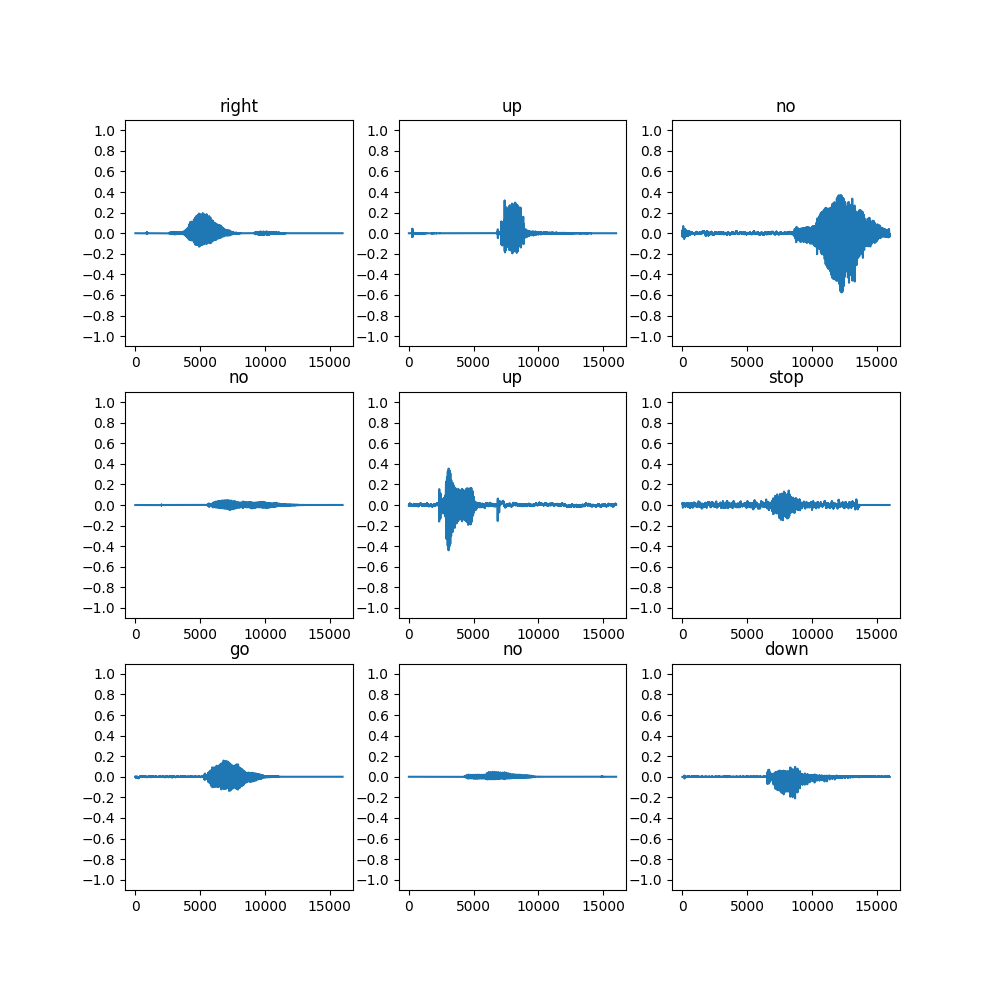

In [14]:
plt.figure(figsize=(10, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [15]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [16]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [17]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1) 
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

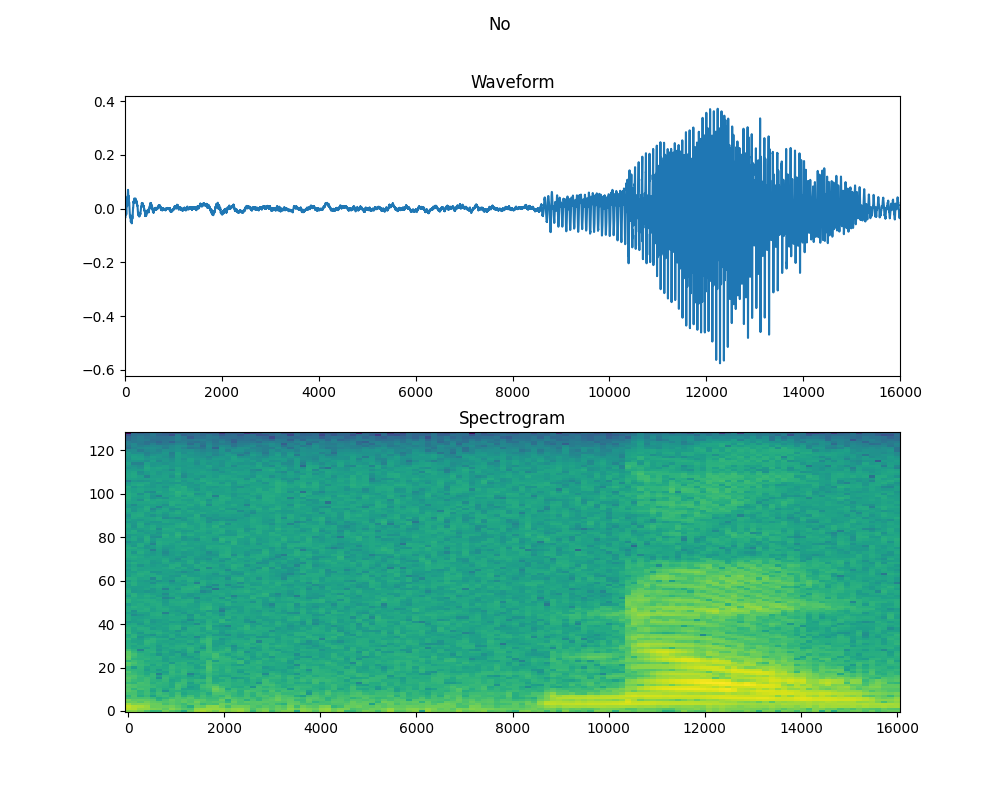

In [18]:
plt.close()
fig, axes = plt.subplots(2, figsize=(10, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')

plt.suptitle(label.title())
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [19]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
train_spectrogram_ds = make_spec_ds(X_train)
val_spectrogram_ds = make_spec_ds(val)
test_spectrogram_ds = make_spec_ds(X_test)

In [21]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

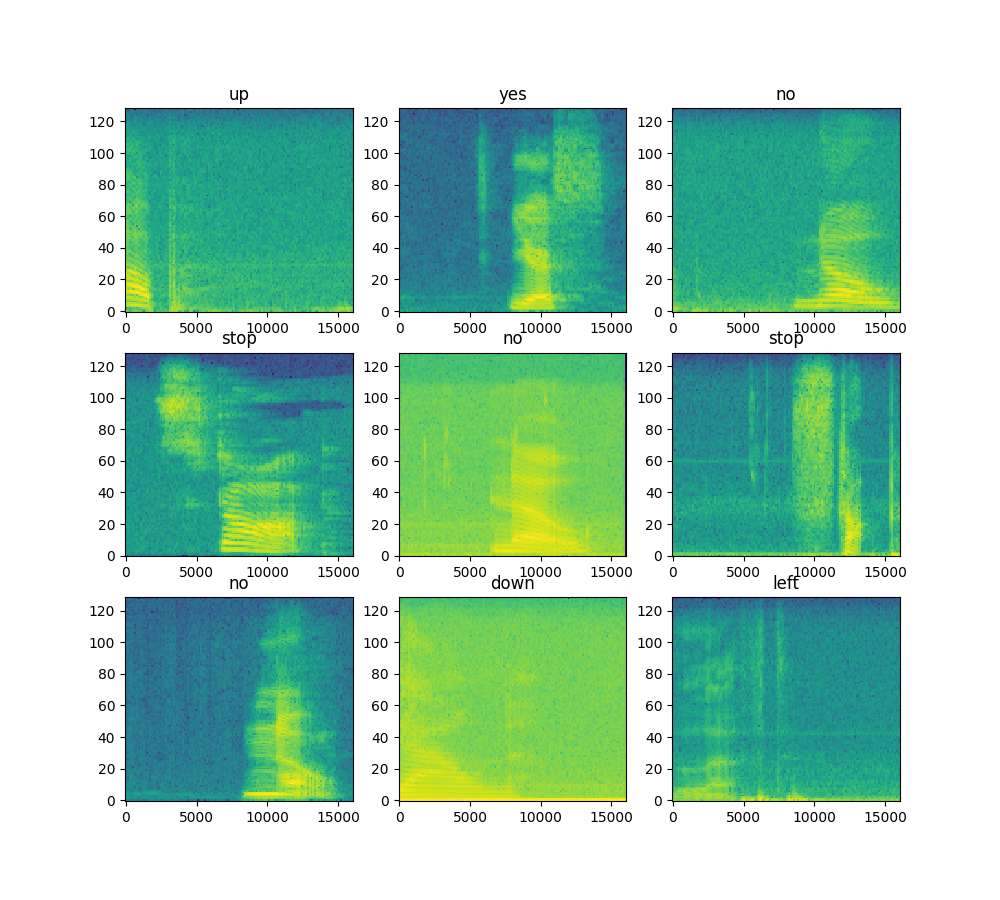

In [22]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [23]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [24]:
example_spectrograms.shape[1:]

TensorShape([124, 129, 1])

In [25]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
 
norm_layer = Normalization() 
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    Input(shape=input_shape),
    # Downsample the input.
    Resizing(32, 32),
    # Normalize.
    norm_layer,
    Conv2D(32, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [27]:

history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 155ms/step - accuracy: 0.2804 - loss: 1.9080 - val_accuracy: 0.6328 - val_loss: 1.2706
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.5750 - loss: 1.2156 - val_accuracy: 0.6953 - val_loss: 0.9134
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.6789 - loss: 0.8847 - val_accuracy: 0.7500 - val_loss: 0.7453
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.7545 - loss: 0.7051 - val_accuracy: 0.7760 - val_loss: 0.7078
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.7752 - loss: 0.6008 - val_accuracy: 0.7969 - val_loss: 0.6317
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.8115 - loss: 0.5448 - val_accuracy: 0.8021 - val_loss: 0.6124
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.8390 - loss: 0.4468 - val_accuracy: 0.8307 - val_loss: 0.5218
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.8595 - loss: 0

Text(0, 0.5, 'Accuracy [%]')

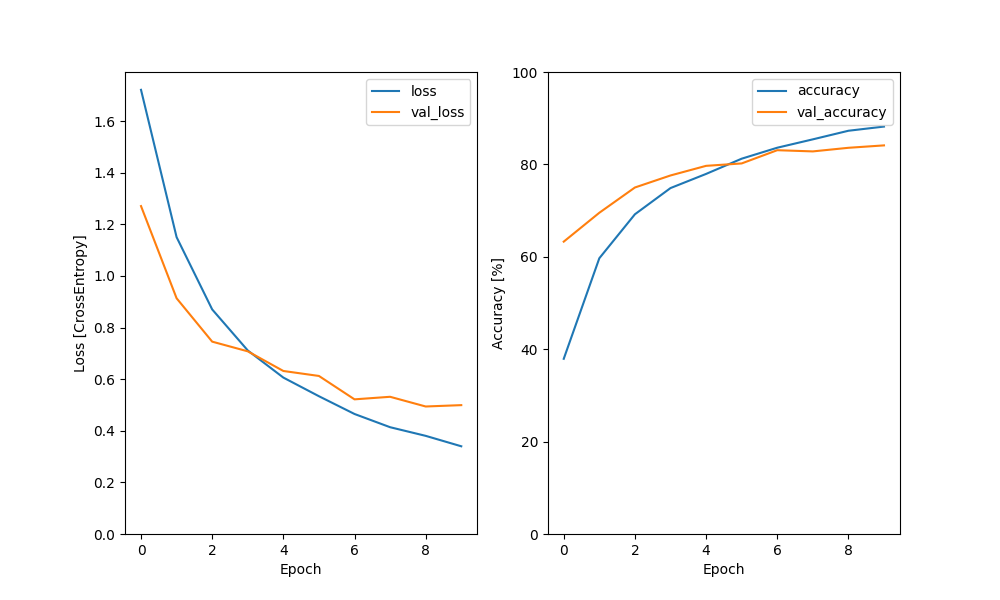

In [28]:
metrics = history.history
plt.close()
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [29]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.8359 - loss: 0.4930


{'accuracy': 0.8377403616905212, 'loss': 0.48980122804641724}

In [30]:
y_pred = model.predict(test_spectrogram_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [31]:
y_pred = tf.argmax(y_pred, axis=1)

In [32]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

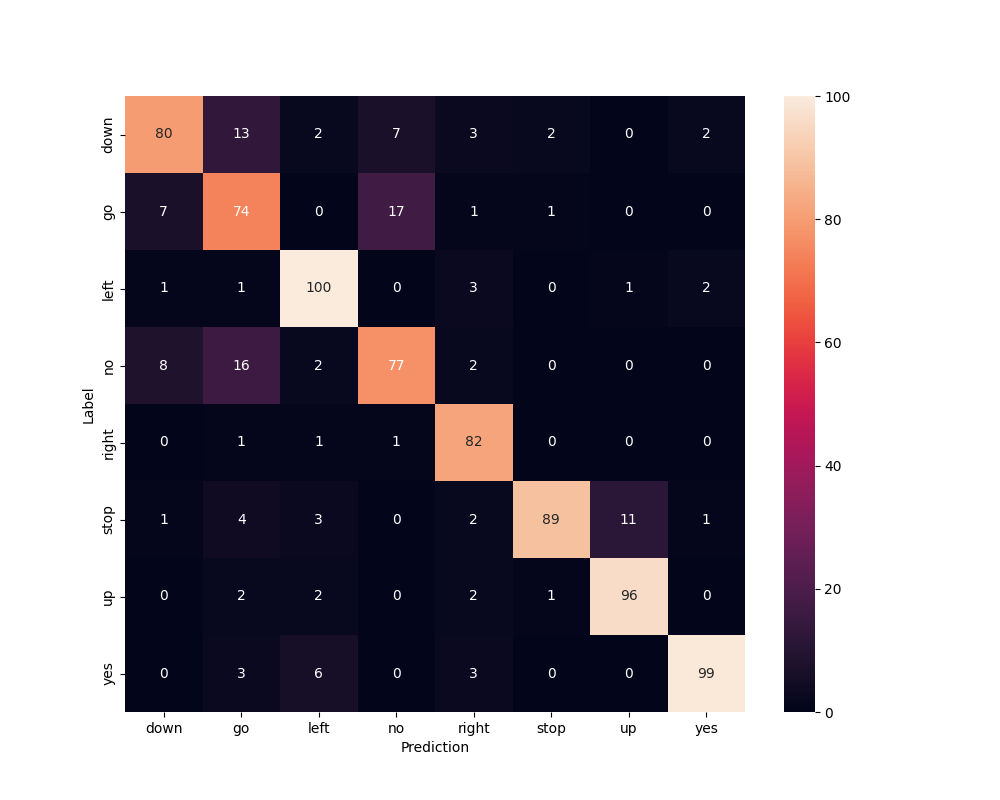

In [33]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

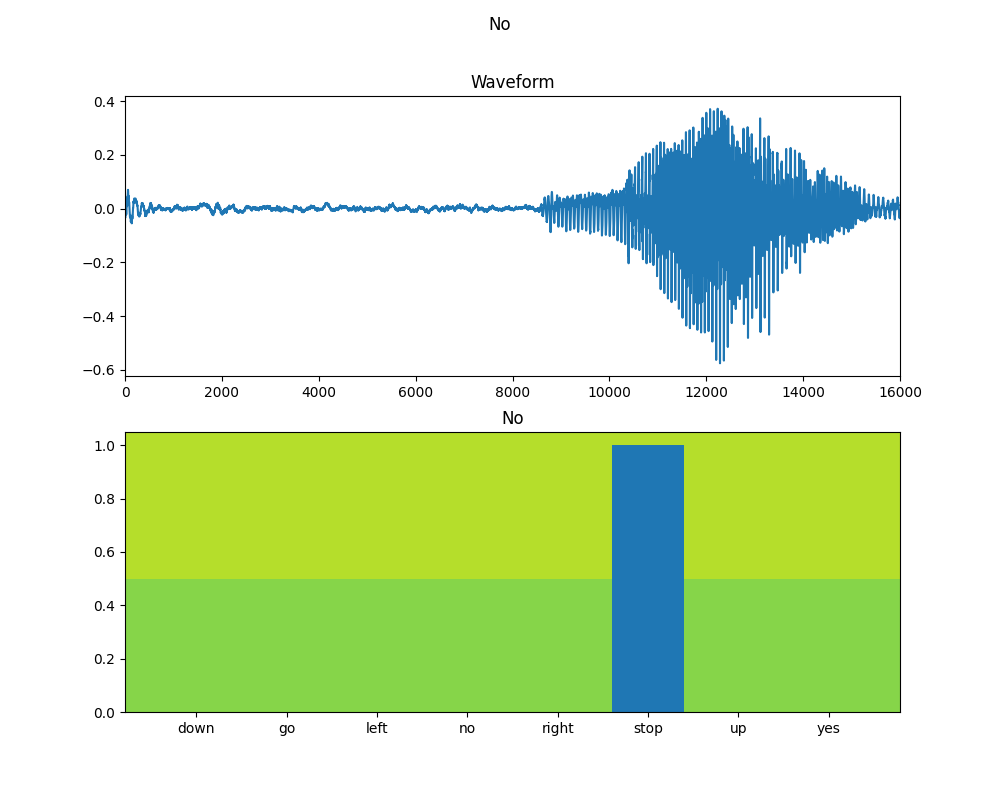

In [34]:
import IPython.display
 
x = data_dir/'stop/1c45ceb2_nohash_1.wav'
x = tf.io.read_file(str(x))


plt.close()

x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names
plt.close()
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000,autoplay=True))

In [35]:
import IPython.display
 
x = 'data/stop/8a28231e_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
display.display(display.Audio(waveform, rate=16000,autoplay=True))

In [36]:
IPython.__version__

'8.23.0'

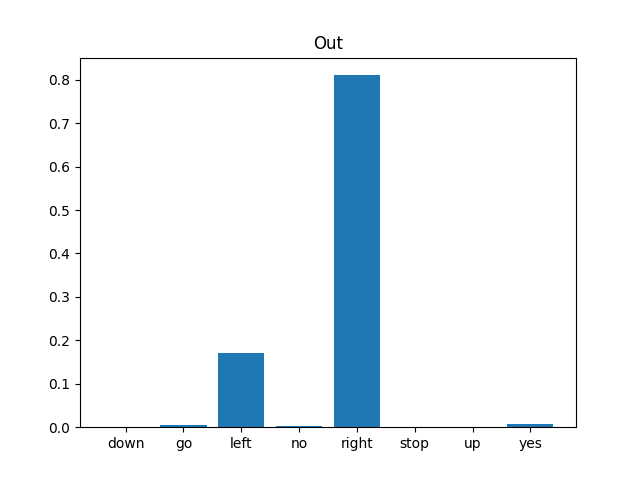

In [45]:
import pyaudio
p = pyaudio.PyAudio()
sabad=16000
stream = p.open(format=pyaudio.paInt16, channels=1, rate=16000,input=True,frames_per_buffer=sabad )
a=stream.read(sabad)

import wave
wf = wave.open("amirreza.wav", 'wb')
wf.setnchannels(1)
wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
wf.setframerate(16000 )
wf.writeframes(b''.join([a]))
wf.close()

x = 'amirreza.wav'
x = tf.io.read_file(str(x))
 

x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names
plt.close()
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Out')
plt.show()
 

In [47]:
model.save_weights('audiopredictionmodel.weights.h5')

In [48]:
model.save("newmodel.h5")